
# Building the HAFFA Logo

The HAFFA logo was originally drawn up by Diane Basta and scanned to provide an image file. That image file has been in use for a long time, appearing on club hats, tee-shirts and the club website. However, since the only available image is a bitmap, scaling the logo up for use on banners, or incorporating it in a badge for use on models or membership cards has not been practical. 

<img src="_images/haffa-logo.jpg">

In this note, we will construct an SVG file that can provide the missing functionality. We will use a Python Jupyter notebook to document how this new logo is being generated from the original club logo.

## Logo Components

The original logo has five basic elements:

1. The US Flag.

2. A heart shape mask used to mask off parts of the flag.

3. A Modeler launching an airplane.

4. A free-flight  model.

5. The text "HAFFA" styled in what looks like the papyrus font.

## Tracing the image file

I started off by using **Snagit**, an image editing tool,  to crop off the modeler, airplane and HAFFA text from the image file. The flag and heart are well defined, so there was no need to attempt to process those parts of the logo image. I broke up the text into the three letters used so each could be processed individually.

Once I had isolated those components, I used **Inkscape** to trace the  parts, producing a rough SVG version of each item. **Inkscape** has a "simplify" command that cleans up the SVG somewhat, at the expense of rounding some areas. The resulting vector form of each component was very messy, since the resolution of the images used was fairly low. 

Finally, I then manually edited the images using **Inkscape**, deleting many of the remaining points to smooth up the final SVG for each item. I did some minor editing to make the data easier t see as well. Here are the basic component files I produced:

### Pilot:

<img src="_images/haffa-pilot.svg">

### Airplane:

<img src="_images/haffa-airplane.svg">

### Letter H:

<img src="_images/haffa-letter-H.svg">

### Letter A:

<img src="_images/haffa-letter-A.svg">

### Letter F:

<img src="_images/haffa-letter-F.svg">

All of these elements stll retain the hand-drawn feel. We may need to tweak them further as we build large format images from the final SVG files we produce.

**inkscape** produces SVG that is a bit odd. For most users, this does not matter. However, My goal was to build a clean SVG file for the club logo, so I decided to manually cut out the needed drawing data from the **inkscape** SVG code and use that to produce an SVG file more readable by humans.

We will use a bit of Python to do this job.

## Processing a Basic SVG file

SVG is a text format, based on XML, which uses "tags" to identify each fundamental component of an image. If you have not seen this type of markup before, the idea is pretty simple. Here is a basic "tag":

    <tag optional_parameters>
      tag body
    </tag>
    
Other tags can be placed in the tag body area producing a nested structure. It is common to indent those nested elements for readability.

SVG defines a lot of standard tag names, each performing some action when the image file is displayed. Some tags cause visible drawing effects to appear. Other tags are more administrative in nature.

For instance, the outermost tag in any SVG file is the **svg** tag itself. This tag defines the drawing canvas to be used for the image. we will see an example of this in a bit.

SVG files can be processed using a number of Python tools. One common tool is **lxml** which can be installed using the standard library installer **pip**. You can inatall **lxml** using this command:

    $ pip install lxml

Once this step finishes, you can check your installation by importing the library:

In [65]:
import lxml

If you see no errors, you are ready to go.

Let's begin by building a simple function that displays the text in an SVG file:

In [66]:
def show(filename):
    with open('_images/%s' % filename) as fin:
        lines = fin.readlines()
    for l in lines:
        print(l.rstrip())

We can now use this function to diaplsy one of our **inkscape** SVG files:

In [67]:
show('haffa-letter-H.svg')

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   version="1.1"
   id="svg159"
   width="233.30176"
   height="200"
   viewBox="0 0 233.30176 200"
   sodipodi:docname="haffa-letter-H.svg"
   inkscape:version="1.0 (4035a4f, 2020-05-01)">
  <metadata
     id="metadata25">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <defs
     id="defs23" />
  <sodipodi:namedview
     inkscape:document-rotation="0"
     p

If you examine this **inkscape** file closly, you will see that it defines a drawing canvas in the **svg** tag, and has a **path** tag that defines the shape to be drawn and the color to use to fill that shape. The shape may be contained inside of a **g** tag which can provide transformation information in case the shape needs to be scaled, moved, or rotated for final display. 

The **path** tag contains the important data used to draw the shape. We will extract those data items and collect each one in a list of items to draw. There will be two kinds of items in this list: command letters, and coordinate pair values. Fortunately, **inkscape** uses spaces to separate these items making is easy for Python to break things up for processing. 

Jupyter Notebook makes it difficult to build code using a top-down approach, so we will build a few utility functons first, then work up to the final management code.

We will need a function that takes an SVG filename and uses **lxml** to parse that file into a structure we can use to extract data. This structure is called a parse tree:

In [68]:
import os
from lxml import etree

def parse(filename):
        fname = os.path.join("_images", filename)
        tree = etree.parse(fname)
        return tree

We can check this function out by processing the same file:

In [69]:
tree = parse("haffa-letter-H.svg")
print(tree)

The tree is a data structure, not something we can print this way!

We will need to extract three basic pieces of data from each file: canvas size (width and height), path data, and fill color. One of the files also has a transform data item in the **g** tag, so we need to check for this as well. To simplify extracting these data items, this, we will build functions for each one:

In [70]:
def get_canvas_size(tree):
    for element in tree.iter():
        tag = element.tag.split('}')[1]
        if tag == 'svg': break
    width = element.get('width')
    height = element.get('height')
    return width, height
        
w,h = get_canvas_size(tree)
print(w,h)

233.30176 200


In [71]:
def get_fill_color(tree):
    for element in tree.iter():
        tag = element.tag.split('}')[1]
        if tag == 'path': break
    style = element.get('style')
    f1 = style.find('fill:')
    style = style[f1+5:]
    f2 = style.find(';')
    if f2>0:
        color = style[:f2]
    else:
        color = style
    return color

color = get_fill_color(tree)
print(color)

#b30000


In [72]:
def get_path_data(tree):
    for element in tree.iter():
        tag = element.tag.split('}')[1]
        if tag == 'path': break
    data = element.get('d').split()
    return data
    
data = get_path_data(tree)
print(data)

['m', '-135.01024,132.70382', 'c', '10.54609,3.28331', '21.06694,-3.94871', '24.20863,-14.05748', '4.83401,-12.31659', '4.18421,-25.82625', '7.88479,-38.447441', '4.573935,-21.167941', '9.167168,-42.343603', '14.707323,-63.284024', '19.235095,-5.954538', '39.279958,2.222467', '58.889842,0.247879', '18.340853,0.452088', '36.9701078,-1.646062', '55.092227,2.271167', '0.790803,20.083306', '-5.016041,39.717921', '-8.910998,59.261021', '-2.763164,11.181582', '-4.782812,22.665968', '-8.1356686,33.631268', '-2.3256387,7.99989', '-9.35474886,14.56234', '-12.7824555,20.60349', '9.4996704,3.40853', '20.1369771,1.19488', '29.9556781,-0.006', '4.274571,-10.41031', '2.242043,-25.10932', '4.4021,-37.099568', '0.325371,-13.547194', '7.011616,-25.690748', '8.520576,-38.895347', '1.485797,-15.289763', '4.23731,-30.443234', '8.0051,-45.294194', '1.084922,-13.9603685', '4.103866,-27.680181', '6.002906,-41.514128', '2.50087,-10.587528', '7.267076,-20.619131', '14.015169,-29.145285', '0.01284,-11.146878', 

In [73]:
def get_translate_data(tree):
    xtranslate = 0
    ytranslate = 0
    tag = None
    for element in tree.iter():
        tag = element.tag.split('}')[1]
        if tag == 'g': break
    if tag:
        data = element.get('transform')
        if data:
            f1 = data.find('(')
            x,y = (data[f1+1:-1]).split(',')
            xtranslate = float(x)
            ytranslate = float(y)
    return xtranslate, ytranslate
        
xt,yt = get_translate_data(tree)
print(xt, yt)

136.94005 65.687287


We now have the tools needed to extract the basic drawing data. We can create a clean SVG file using the data provided by our new functions.

In [74]:
def clean_svg(filename, data, xt, yt, color, width, height):
    fname = os.path.join('_images', filename)
    svg = """<svg xmlns="http://www.w3.org/2000/svg" width="%s" height="%s">""" % (width, height)
    svg += """  
  <g transform="translate(%.2f,%.2f)">
    <path d="
""" % (xt,yt)
    for item in data:
        svg += item
        svg += ' '
    svg += """
    "
      style="fill:%s"
    />
  </g>
</svg>""" % color
    with open(fname, "w") as fout:
        fout.write(svg)
        
clean_svg('clean-haffa-letter-H.svg', data, xt, yt, color, w, h)
show('clean-haffa-letter-H.svg')

<svg xmlns="http://www.w3.org/2000/svg" width="233.30176" height="200">
  <g transform="translate(136.94,65.69)">
    <path d="
m -135.01024,132.70382 c 10.54609,3.28331 21.06694,-3.94871 24.20863,-14.05748 4.83401,-12.31659 4.18421,-25.82625 7.88479,-38.447441 4.573935,-21.167941 9.167168,-42.343603 14.707323,-63.284024 19.235095,-5.954538 39.279958,2.222467 58.889842,0.247879 18.340853,0.452088 36.9701078,-1.646062 55.092227,2.271167 0.790803,20.083306 -5.016041,39.717921 -8.910998,59.261021 -2.763164,11.181582 -4.782812,22.665968 -8.1356686,33.631268 -2.3256387,7.99989 -9.35474886,14.56234 -12.7824555,20.60349 9.4996704,3.40853 20.1369771,1.19488 29.9556781,-0.006 4.274571,-10.41031 2.242043,-25.10932 4.4021,-37.099568 0.325371,-13.547194 7.011616,-25.690748 8.520576,-38.895347 1.485797,-15.289763 4.23731,-30.443234 8.0051,-45.294194 1.084922,-13.9603685 4.103866,-27.680181 6.002906,-41.514128 2.50087,-10.587528 7.267076,-20.619131 14.015169,-29.145285 0.01284,-11.146878 -18.523894,

The coordinate data in this file has a precision that far exceeds anything we might actually need. We can clean that up by processing the data list. Here is a routine that does this.

In [75]:
def normalize_path_data(data):
    norm = []
    for item in data:
        if item.isalpha():
            norm.append(item)
        else:
            x,y = item.split(',')
            fx = float(x)
            fy = float(y)
            norm.append("%.2f,%.2f" % (fx,fy))
    return norm
        
norm = normalize_path_data(data)
print(norm)

['m', '-135.01,132.70', 'c', '10.55,3.28', '21.07,-3.95', '24.21,-14.06', '4.83,-12.32', '4.18,-25.83', '7.88,-38.45', '4.57,-21.17', '9.17,-42.34', '14.71,-63.28', '19.24,-5.95', '39.28,2.22', '58.89,0.25', '18.34,0.45', '36.97,-1.65', '55.09,2.27', '0.79,20.08', '-5.02,39.72', '-8.91,59.26', '-2.76,11.18', '-4.78,22.67', '-8.14,33.63', '-2.33,8.00', '-9.35,14.56', '-12.78,20.60', '9.50,3.41', '20.14,1.19', '29.96,-0.01', '4.27,-10.41', '2.24,-25.11', '4.40,-37.10', '0.33,-13.55', '7.01,-25.69', '8.52,-38.90', '1.49,-15.29', '4.24,-30.44', '8.01,-45.29', '1.08,-13.96', '4.10,-27.68', '6.00,-41.51', '2.50,-10.59', '7.27,-20.62', '14.02,-29.15', '0.01,-11.15', '-18.52,-1.56', '-23.46,3.33', '-7.88,7.84', '-3.36,8.80', '-7.32,22.43', 'C', '33.54,-24.62', '33.69,-0.80', '25.56,2.37', '6.58,1.88', '-12.39,0.02', '-31.36,0.52', 'c', '-17.99,-1.97', '-36.15,-1.24', '-54.14,-3.26', '0.52,-14.86', '5.41,-29.15', '5.77,-44.03', '1.92,-4.34', '13.25,-18.48', '4.15,-18.40', '-6.78,6.10', '-18.69,

In [76]:
clean_svg('clean-haffa-letter-H.svg', norm, xt, yt, color, w, h)
show('clean-haffa-letter-H.svg')

<svg xmlns="http://www.w3.org/2000/svg" width="233.30176" height="200">
  <g transform="translate(136.94,65.69)">
    <path d="
m -135.01,132.70 c 10.55,3.28 21.07,-3.95 24.21,-14.06 4.83,-12.32 4.18,-25.83 7.88,-38.45 4.57,-21.17 9.17,-42.34 14.71,-63.28 19.24,-5.95 39.28,2.22 58.89,0.25 18.34,0.45 36.97,-1.65 55.09,2.27 0.79,20.08 -5.02,39.72 -8.91,59.26 -2.76,11.18 -4.78,22.67 -8.14,33.63 -2.33,8.00 -9.35,14.56 -12.78,20.60 9.50,3.41 20.14,1.19 29.96,-0.01 4.27,-10.41 2.24,-25.11 4.40,-37.10 0.33,-13.55 7.01,-25.69 8.52,-38.90 1.49,-15.29 4.24,-30.44 8.01,-45.29 1.08,-13.96 4.10,-27.68 6.00,-41.51 2.50,-10.59 7.27,-20.62 14.02,-29.15 0.01,-11.15 -18.52,-1.56 -23.46,3.33 -7.88,7.84 -3.36,8.80 -7.32,22.43 C 33.54,-24.62 33.69,-0.80 25.56,2.37 6.58,1.88 -12.39,0.02 -31.36,0.52 c -17.99,-1.97 -36.15,-1.24 -54.14,-3.26 0.52,-14.86 5.41,-29.15 5.77,-44.03 1.92,-4.34 13.25,-18.48 4.15,-18.40 -6.78,6.10 -18.69,7.82 -23.16,15.11 4.56,9.96 0.02,20.72 -0.29,31.06 -3.72,28.61 -7.59,57.54 -17.15

This is a bit cleaner. 

## Removing Relative Coordinates

For reference purposes, we can inspect the **path** commands to see ewhat they actually will draw.most of these items are coordinate pairs. The items that are simple leters are SVG drawing commands. To understand them, we need to examine what each command does.

SVG uses a basic dimensionless coordinate system. Normally, these dimensions refer to pixels on a screen, but we can make them dimensional with a little work. The **x** coordinate runs left to right. The **y** coordinate runs from top to bottom, which is a little odd for humans. The drawing commands move a virtual pen around in this space, and may define a line of simply move the pen frm place to place leaving no line. In out output we only see a few of the available SVG drawing commands. These commands may be upper case, or lower case. If they are upper case, the coordinates needed are absolute. If they are lower case, the provided coordinates are relative to the last point drawn. In our file, most commands are relative, so the coordinates shown are not the final values. We need to do some math to get the actual drawing coordinates. Here are the commands we see here:

1. **m** - move the pen to the specified coordinate (since we start off at 0,0, the provide coordinates are actually absolute values

2. **c** - draw a bezier curve. The final coordinate and two control points are specified.

3. **l** draw a straight line from the last point specified  to the next coordinate.

4. **z** - close the current path by drawing a straight line from the last point specified to the first point in the path. The resulting area can be filled. The fill color is specified by the **style** paramener.

If a command is followed by more coordinate values than the command needs, the same command is implied. This continues until another literal command letter is seen.

In the code that follows, we will process the path data and eliminate the relative commands. The resulting drawing commands will now include absolute dimensions, which might be easier to use when we combine these elements into the final logo SVG file.



In [77]:
x = xt
y = yt
i = 0
xmin = 5000
ymin = 5000
xmax = -5000
ymax = -5000

numitems = len(norm)
command = ''

def split_coord(cstr):
    global xt, yt
    x,y = cstr.split(',')
    x = float(x)
    y = float(y)
    return x,y

def move(i, relative):
    global x,y, xt, yt, xmax, ymax, newpath
    
    dx,dy = split_coord(norm[i])
    if relative:
        x += dx
        y += dy
    else:
        x = dx
        y = dy
    xs = "%.2f" % x
    ys = "%.2f" % y
    if x > xmax: xmax = x
    if y > ymax: ymax = y
    newpath.extend([xs,ys])
    return 1
            
def curve(i, relative):
    global x, y, xmax, ymax, newpath
    cx1,cy1 = split_coord(norm[i])
    cx2,cy2 = split_coord(norm[i+1])
    cx3,cy3 = split_coord(norm[i+2])
    if relative:
        cx1 = x + cx1
        cy1 = y + cy1
        cx2 = x + cx2
        cy2 = y + cy2
        x += cx3 
        y += cy3
    else:
        x = cx3
        y = cy3
    cx1 = "%.2f" % cx1
    cy1 = "%.2f" % cy1
    cx2 = "%.2f" % cx2
    cy2 = "%.2f" % cy2
    xs = "%.2f" % x
    ys = "%.2f" % y
    newpath.extend([cx1,cy1,cx2,cy2,xs,ys])
    if x > xmax: xmax = x
    if y > ymax: ymax = y
    return 3

def close(i, relative):
    return 1
    
def commands(argument, i):
    relative = argument.islower()
    switcher = {
        'm' : move,
        'M' : move,
        'c' : curve,
        'C' : curve,
        'l' : move,
        'L' : move,
        'z' : close,
        'Z' : close,
    }
    func = switcher.get(argument, lambda: "Invalid command")
    return func(i, relative)
    
def gen_svg(xmax, ymax, path, color):
    svg = """<svg xmlns="http://www.w3.org/2000/svg"
xmlns:xlink="http://www.w3.org/1999/xlink"
width="%d" height="%d">
<path d="
"""% (xmax, ymax)
    for item in path:
        svg += str(item)
        svg += " "
    svg += """
    "
    style="fill:%s"
  />
</svg>
""" % (color)
    print(svg)

newpath = []
while i < numitems:
    command = norm[i]
    i += 1
    newpath.append(command.upper())
    done = False
    while not done:
        i += commands(command,i)
        if x > xmax: xmax = x
        if y > ymax: ymax = y
        if x < xmin: xmin = x
        if y < ymin: ymin = y
            
        done = i >= numitems or  norm[i].isalpha()
gen_svg(xmax, ymax, newpath, color)
        

<svg xmlns="http://www.w3.org/2000/svg"
xmlns:xlink="http://www.w3.org/1999/xlink"
width="203" height="198">
<path d="
M 1.93 198.39 C 12.48 201.67 23.00 194.44 26.14 184.33 30.97 172.01 30.32 158.50 34.02 145.88 38.59 124.71 43.19 103.54 48.73 82.60 67.97 76.65 88.01 84.82 107.62 82.85 125.96 83.30 144.59 81.20 162.71 85.12 163.50 105.20 157.69 124.84 153.80 144.38 151.04 155.56 149.02 167.05 145.66 178.01 143.33 186.01 136.31 192.57 132.88 198.61 142.38 202.02 153.02 199.80 162.84 198.60 167.11 188.19 165.08 173.49 167.24 161.50 167.57 147.95 174.25 135.81 175.76 122.60 177.25 107.31 180.00 92.16 183.77 77.31 184.85 63.35 187.87 49.63 189.77 35.80 192.27 25.21 197.04 15.18 203.79 6.65 203.80 -4.50 185.27 5.09 180.33 9.98 172.45 17.82 176.97 18.78 173.01 32.41 C 33.54 -24.62 33.69 -0.80 25.56 2.37 6.58 1.88 -12.39 0.02 -31.36 0.52 C -49.35 -1.45 -67.51 -0.72 -85.50 -2.74 -84.98 -17.60 -80.09 -31.89 -79.73 -46.77 -77.81 -51.11 -66.48 -65.25 -75.58 -65.17 -82.36 -59.07 -94.27 -57.35 -98

this code is not being used for the current project, but may be useful later.

Now, we can build clean files for all of our component parts:

In [80]:
files = [
    'haffa-letter-A.svg',
    'haffa-letter-F.svg',
    'haffa-letter-H.svg',
    'haffa-pilot.svg',
    'haffa-airplane.svg'
]

for fname in files:
    tree = parse(fname)
    w,h = get_canvas_size(tree)
    color = get_fill_color(tree)
    xt,yt = get_translate_data(tree)
    data = get_path_data(tree)
    norm = normalize_path_data(data)
    
    cname = 'clean-' + fname
    clean_svg(cname, norm, xt, yt, color, w, h)
    show(cname)

<svg xmlns="http://www.w3.org/2000/svg" width="225" height="200">
  <g transform="translate(0.00,0.00)">
    <path d="
m 12.00,200.00 c 15.22,-1.96 18.85,-24.62 31.04,-33.24 17.72,-19.03 25.81,-35.79 41.73,-29.03 23.99,2.39 63.47,-2.64 87.53,0.18 17.48,0.35 15.27,-2.50 18.67,12.18 4.55,14.76 3.37,41.15 14.46,49.91 27.69,6.11 19.32,-18.74 10.62,-32.97 -12.19,-15.46 -7.82,-34.35 -17.79,-52.58 -6.65,-21.99 -13.07,-41.65 -17.81,-63.26 -3.26,-13.89 -4.24,-33.35 -11.89,-50.24 -20.09,5.07 -21.86,21.14 -35.01,32.89 -11.16,20.22 -31.38,41.06 -44.95,60.05 -10.53,20.95 -31.00,35.76 -44.60,55.25 -12.72,18.27 -28.51,33.50 -44.47,49.15 -1.45,3.48 9.48,1.09 12.47,1.71 z m 84.61,-73.38 c -24.45,5.77 -14.89,-10.96 -3.91,-21.01 13.22,-19.74 35.95,-47.59 51.08,-66.31 10.57,-18.41 17.03,-10.93 18.16,8.02 9.38,17.91 13.75,39.66 18.17,63.62 11.16,21.48 -19.04,13.43 -34.84,15.17 -16.10,2.76 -32.39,-0.04 -48.66,0.50 z
    "
      style="fill:#b30000"
    />
  </g>
</svg>
<svg xmlns="http://www.w3.org/2000/svg

As a check, let's display these files and make sure each one looks correct.

### Pilot:

<img src="_images/haffa-pilot.svg">

### Airplane:

<img src="_images/haffa-airplane.svg">

### Letter H:

<img src="_images/haffa-letter-H.svg">

### Letter A:

<img src="_images/haffa-letter-A.svg">

### Letter F:

<img src="_images/haffa-letter-F.svg">

These look fine. We still have two basic items to generate: the flag, and the heart shape that will mask that flag. Both of these elements will be set up in a separate notebook.

In [82]:
flag = draw.Drawing(flag_height, flag_width)

# Draw an irregular polygon
flag.append(draw.Lines(0, 0,
                    flag_width, 0,
                    flag_width, flag_height,
                    0, flag_height,
                    close=True,
            fill='red',
            stroke='black'))
flag.setRenderSize(600)

NameError: name 'draw' is not defined

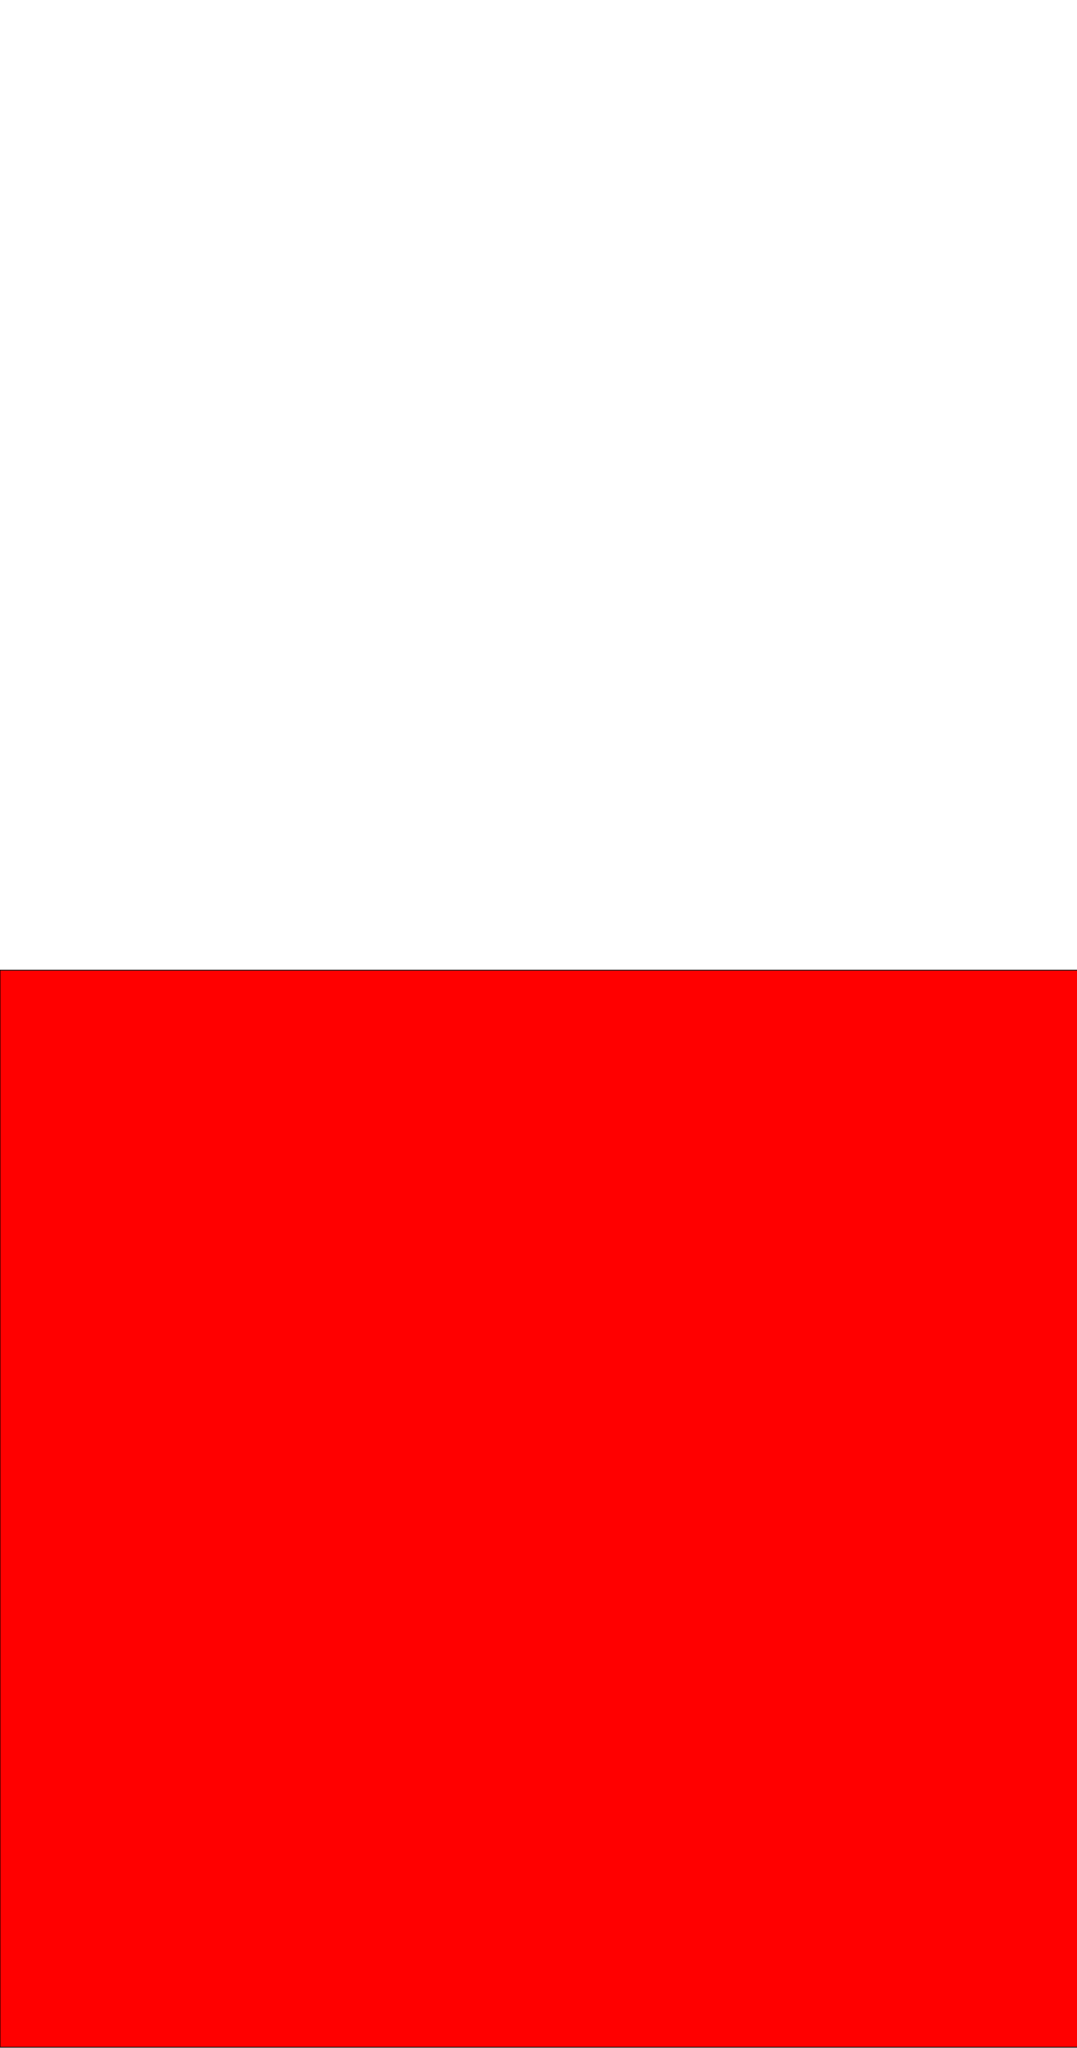

In [39]:
flag